In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

import subprocess
from genericpath import exists
import os

from taunet.database import PATH, DATASET
from taunet.fields import FEATURES, TRUTH_FIELDS, OTHER_TES
from taunet.computation import tf_mdn_loss, VARNORM

In [3]:
regressor = tf.keras.models.load_model('cache/gauss_simple_mdn.h5', custom_objects={'MixtureNormal': tfp.layers.MixtureNormal, 'tf_mdn_loss': tf_mdn_loss})

2022-08-03 09:37:04.900321: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 09:37:04.900641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-03 09:37:04.996306: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [80]:
from taunet.database import file_list, retrieve_arrays, debug_mode, select_norms
from taunet.computation import applySSNormalizeTest, getVarIndices

def testing_data(
    path, dataset, features, plotting_fields, regressor, 
    nfiles=-1, select_1p=False, select_3p=False, tree_name='CollectionTree',
    saveToCache=False, useCache=False, optional_path='', 
    no_normalize=False, no_norm_target=False, normIndices=range(9), debug=False, multiMDN=False):
    """
    """
    import numpy as np

    if useCache:
        print('Using cache')
        return np.load('data/testingData_temp.npy')

    import uproot
    import awkward as ak

    # from numpy.lib.recfunctions import append_fields

    _files = file_list(path, dataset)
    # build unique list of variables to retrieve
    _fields_to_lookup = list(set(features + plotting_fields))

    # load normalization from training if used
    if not no_normalize or not no_norm_target:
        if optional_path == '':
            norms = np.load('data/normFactors.npy')
        else:
            norms = np.load(os.path.join(optional_path, 'normFactors.npy'))

    _arrs = []
    _arrs_above = []
    _arrs_below = []
    varnom = select_norms(VARNORM, normIndices) # variables to normalize
    for i_f, _file in enumerate(_files):
        if nfiles > 0 and i_f > nfiles:
            break
        with uproot.open(_file) as up_file:
            tree = up_file[tree_name]
            print('file {} / {} -- entries = {}'.format(i_f, len(_files), tree.num_entries))
            if debug:
                a = debug_mode(
                    tree,
                    _fields_to_lookup, 
                    cut = 'EventInfoAuxDyn.eventNumber%3 == 0',
                    select_1p=select_1p,
                    select_3p=select_3p)
            else:
                a = retrieve_arrays(
                    tree,
                    _fields_to_lookup, 
                    cut = 'EventInfoAuxDyn.eventNumber%3 == 0',
                    select_1p=select_1p,
                    select_3p=select_3p)
            a = a[ a['TauJetsAuxDyn.ptIntermediateAxisEM/TauJetsAuxDyn.ptIntermediateAxis'] < 25. ]
            a = a[ a['TauJetsAuxDyn.ptPanTauCellBased/TauJetsAuxDyn.ptCombined'] < 25. ] 
            a = a[ a['TauJetsAuxDyn.ptIntermediateAxis/TauJetsAuxDyn.ptCombined'] < 25. ]
            f = np.stack(
                [ak.flatten(a[__feat]).to_numpy() for __feat in features])
            # print('Shape of f is {}'.format(np.shape(f)))
            # Optionally normalize data if done in the training
            if not no_normalize:
                f = applySSNormalizeTest(f, norms, vars=getVarIndices(features, varnom))
                print('Normalizing input data to regressor')
            # find mu and sigma for each 
            dist = regressor(f.T)
            means = dist.tensor_distribution.components_distribution.tensor_distribution.mean().numpy()
            stddevs = dist.tensor_distribution.components_distribution.tensor_distribution.stddev().numpy()
            cut1 = (stddevs/means < 1).flatten()
            cut2 = (stddevs/means >= 1).flatten()
            f1 = f.T[cut1]
            f2 = f.T[cut2]
            regressed_target1 = regressor.predict(f1)
            regressed_target2 = regressor.predict(f2)
            regressed_target = regressor.predict(f.T)
            if not no_norm_target:
                # If target was normalized, revert to original
                # Last element of variable "norms" contains mean (element 0) 
                # and std (element 1) of target. 
                regressed_target = norms[len(norms)-1][1] * regressed_target + norms[len(norms)-1][0]
                regressed_target1 = norms[len(norms)-1][1] * regressed_target1 + norms[len(norms)-1][0]
                regressed_target2 = norms[len(norms)-1][1] * regressed_target2 + norms[len(norms)-1][0]
                print('Returning data to orginal format for plotting')
            regressed_target = regressed_target.reshape((regressed_target.shape[0], ))
            regressed_target1 = regressed_target1.reshape((regressed_target1.shape[0], ))
            regressed_target2 = regressed_target2.reshape((regressed_target2.shape[0], ))
            _arr = np.stack([ak.flatten(a[_var]).to_numpy() for _var in plotting_fields], axis=1)
            _arr_above = _arr[cut1]
            _arr_below = _arr[cut2]
            print(len(_arr), " ", sum(cut2), " ", len(_arr_below), " ", len(regressed_target2), " ", len(f2))
            _arr = np.insert(_arr, 0, regressed_target, axis=1)
            _arr_above = np.insert(_arr_above, 0, regressed_target1, axis=1)
            _arr_below = np.insert(_arr_below, 0, regressed_target2, axis=1)
            _arr = np.core.records.fromarrays(_arr.transpose(), names=[_var for _var in plotting_fields] + ['regressed_target'])
            _arr_above = np.core.records.fromarrays(_arr_above.transpose(), names=[_var for _var in plotting_fields] + ['regressed_target'])
            _arr_below = np.core.records.fromarrays(_arr_below.transpose(), names=[_var for _var in plotting_fields] + ['regressed_target'])
            print(len)
            _arrs += [_arr]
            _arrs_above += [_arr_above]
            _arrs_below += [_arr_below]

    print("Variables normalized: {}".format(list(features[i] for i in getVarIndices(features, VARNORM))))
    _arrs = np.concatenate(_arrs)
    _arrs_above = np.concatenate(_arrs_above)
    _arrs_below = np.concatenate(_arrs_below)
    print('Total testing input = {}'.format(_arrs.shape))
    if saveToCache:
        np.save('data/testingData_temp', _arrs)
        print('Saving data to cache')
    return _arrs, _arrs_above, _arrs_below

In [81]:
d, d_above, d_below = testing_data(
    PATH, DATASET, FEATURES, TRUTH_FIELDS + OTHER_TES, regressor, nfiles=3, debug=True)

taunet.database:INFO: Looking in folder /Users/miles_cb/cernbox/TES_dataset
taunet.database:INFO: Gathering files from dataset group.perf-tau.MC20d_StreamTES.425200.Pythia8EvtGen_A14NNPDF23LO_Gammatautau_MassWeight_v3_output.root
taunet.database:INFO: Found 5 files
taunet.database:INFO: Taking 1 chunck with 200000 events from file


file 0 / 5 -- entries = 2081707
Normalizing input data to regressor
Returning data to orginal format for plotting
99339   12167   12167   12167   12167
<built-in function len>


taunet.database:INFO: Taking 1 chunck with 200000 events from file


file 1 / 5 -- entries = 1423859
Normalizing input data to regressor
Returning data to orginal format for plotting
99256   12028   12028   12028   12028
<built-in function len>
Variables normalized: ['TauJetsAuxDyn.mu', 'TauJetsAuxDyn.nVtxPU', 'TauJetsAuxDyn.rho', 'TauJetsAuxDyn.ClustersMeanCenterLambda', 'TauJetsAuxDyn.ClustersMeanFirstEngDens', 'TauJetsAuxDyn.ClustersMeanSecondLambda', 'TauJetsAuxDyn.ptCombined', 'TauJetsAuxDyn.etaPanTauCellBased', 'TauJetsAuxDyn.ptTauEnergyScale']
Total testing input = (198595,)


In [74]:
def get_quantile_width(arr, cl=0.68):
    """
    """
    q1 = (1. - cl) / 2.
    q2 = 1. - q1
    y = np.quantile(arr, [q1, q2])
    width = (y[1] - y[0]) / 2.
    return width


def response_curve(res, var, bins):
    """
    """
    _bin_centers = []
    _bin_errors = []
    _means = []
    _mean_stat_err = []
    _resol = []
    for _bin in bins:
        a = res[(var > _bin[0]) & (var < _bin[1])]
        if len(a) == 0:
            print('Bin was empty! Moving on to next bin')
            continue
        _means += [np.mean(a)]
        _mean_stat_err += [np.std(a, ddof=1) / np.sqrt(np.size(a))]
        _resol += [get_quantile_width(a)]
        _bin_centers += [_bin[0] + (_bin[1] - _bin[0]) / 2]
        _bin_errors += [(_bin[1] - _bin[0]) / 2]
    return np.array(_bin_centers), np.array(_bin_errors), np.array(_means), np.array(_mean_stat_err), np.array(_resol)

In [82]:
def plot_thang(d):
    response_reg = d['regressed_target'] * d['TauJetsAuxDyn.ptCombined'] / d['TauJetsAuxDyn.truthPtVisDressed']
    response_ref = d['TauJetsAuxDyn.ptFinalCalib'] / d['TauJetsAuxDyn.truthPtVisDressed']
    response_comb = d['TauJetsAuxDyn.ptCombined'] / d['TauJetsAuxDyn.truthPtVisDressed']
    truth_pt = d['TauJetsAuxDyn.truthPtVisDressed']

    bins = [
        # (0, 10),
        (10, 20),
        (20, 30),
        (30, 40),
        (40, 50),
        (50, 60),
        (60, 70),
        (70, 80),
        (80, 90),
        (90, 100),
        (100, 150),
        (150, 200),
    ]

    bins_reg, bin_errors_reg, means_reg, errs_reg, resol_reg = response_curve(response_reg, truth_pt, bins)
    bins_ref, bin_errors_ref, means_ref, errs_ref, resol_ref = response_curve(response_ref, truth_pt, bins)
    bins_comb, bin_errors_comb, means_comb, errs_comb, resol_comb = response_curve(response_comb, truth_pt, bins)

    fig = plt.figure(figsize=(5,5), dpi = 100)
    plt.ticklabel_format(axis='y',style='sci', scilimits=(-3,3))
    plt.errorbar(bins_comb, means_comb, errs_comb, bin_errors_comb, fmt='o', color='black', label='Combined')
    plt.errorbar(bins_ref, means_ref, errs_ref, bin_errors_ref, fmt='o', color='red', label='Final')
    plt.errorbar(bins_reg, means_reg, errs_reg, bin_errors_reg, fmt='o', color='purple', label='This work')
    plt.grid(color='0.95')
    plt.ylabel('Predicted $p_{T}(\\tau_{had-vis})$ / True $p_{T}(\\tau_{had-vis})$', loc = 'top')
    plt.xlabel('True $p_{T}(\\tau_{had-vis})$ [GeV]', loc = 'right')
    plt.legend()
    #plt.savefig(os.path.join(plotSaveLoc, 'plots/tes_mdn_response_vs_truth_pt.pdf'))
    #plt.close(fig) 

    fig = plt.figure(figsize=(5,5), dpi = 100)
    plt.plot(bins_ref, 100 * resol_ref, color='red', label='Final')
    plt.plot(bins_ref, 100 * resol_comb, color='black', label='Combined')
    plt.plot(bins_ref, 100 * resol_reg, color='purple', label='This work')
    plt.ylabel('$p_{T}(\\tau_{had-vis})$ resolution [\%]', loc = 'top')
    plt.xlabel('True $p_{T}(\\tau_{had-vis})$ [GeV]', loc = 'right')
    plt.legend()
    #plt.savefig(os.path.join(plotSaveLoc, plotSaveName))
    #plt.close(fig)

    plt.show()

Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin


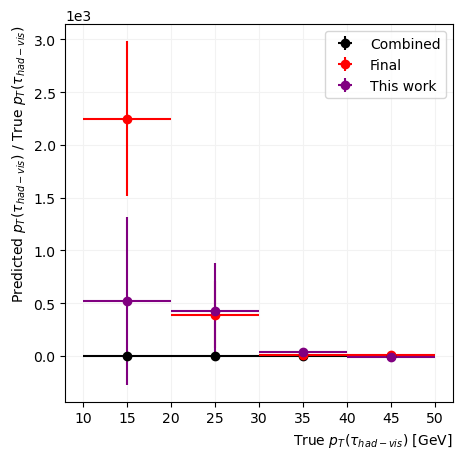

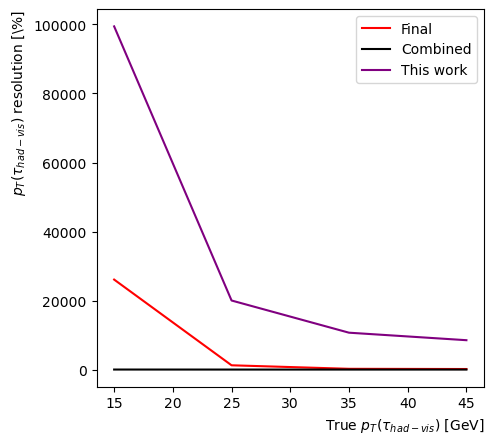

In [76]:
plot_thang(d)

Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin


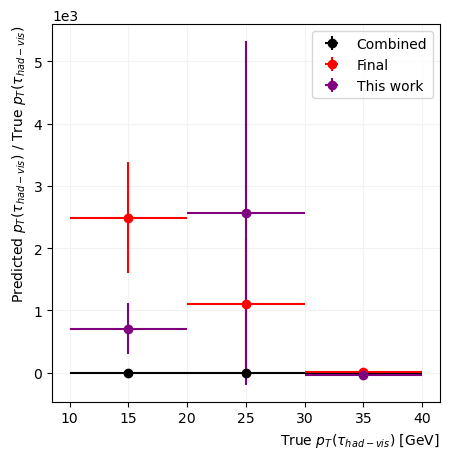

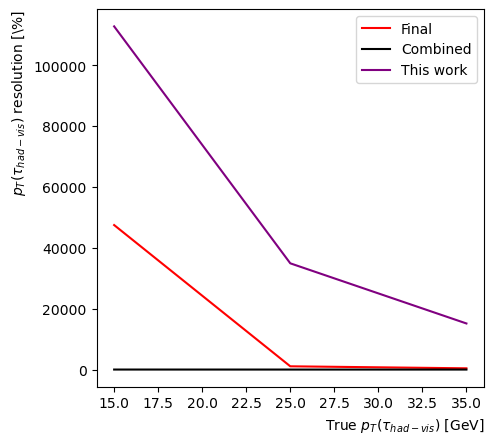

In [83]:
plot_thang(d_above)

Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin
Bin was empty! Moving on to next bin


/Users/miles_cb/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/miles_cb/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


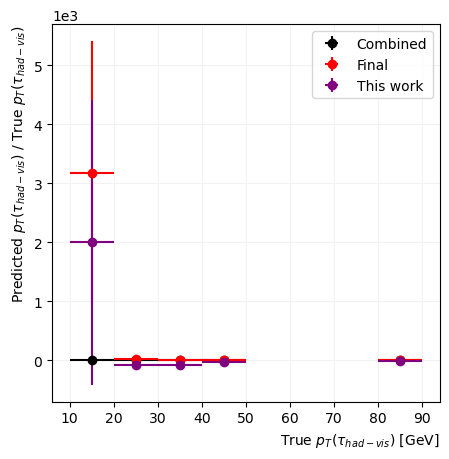

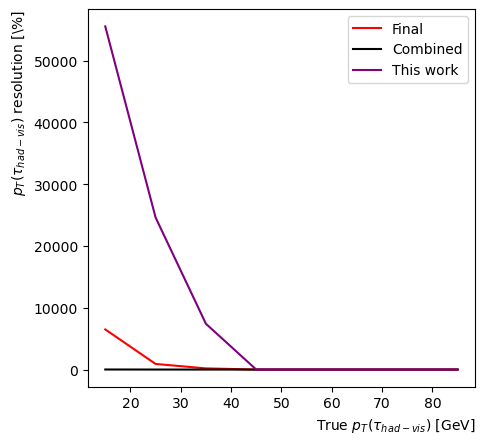

In [84]:
plot_thang(d_below)